(antena_selection)=
# Introducción.

En este apartado vamos a mostrar dos ejemplos de indudable interés para hacer una optimización de problemas encontrados en el mundo real. En el primero de los ejemplos, vamos a contar con uan serie de antenas con un radio de acción igual en todas ellas. De lo que se tratará es de encontrar la menor cantidad de antenas posibles, de tal manera que entre ellas nos haya ningún punto en comúnn en su radio de acción.

En el segundo ejemplo, vamos a tratar un conjunto de ubicación de antenas dentro del territorio de Alemanía, y lo que trataremos es de ubicar otras antenas, de manera que se encuentren a una distancia máxima de las antenas ya existentes. 

Procedemos a continuación a resolver el primer problema. En la imagen siguiente, se muestra de forma gráfica lo que pretendemos resolver. Tenemos un conjunto de antenas, con un radio de acción determinado, indicado en el gráfico por un círculo que rodea a cada nodo. Se trata de encontra el máximo número de nodos, pero que no haya interferencias en los nodos seleccionados.

Para resolver el problema, definimos el gráfo de la derecha, de manera que cuando hay interferencia entre dos puntos, se trazará un arco que una esos dos puntos. Entonces, al final de lo que se trata en de encontrar el máximo número de puntos, pero de tal manera que entre ellos no hay ningún arco que los una

![Selección de antenas](../img/AntenasSelection.PNG)
```{index} maximum independent set problem
```
Este problema de optimización es conocido como *maximum independent set y <a href="https://en.wikipedia.org/wiki/Maximal_independent_set" target="_blank"> en este enlace podemos ver más detalles sobre ello </a>. Así pues, nuestro objetivo es maximizar el número de nodos en un conjunto, con la restricción de que el conjunto no contenga aristas. Para resolver en un sistema D-Wave, podemos reformular este problema como un problema de optimización binaria cuadrática sin restricciones (QUBO). 

Para seguir este problema, también puede ser interesante <a href="https://www.youtube.com/watch?v=ckJ59gsFllU" target="_blank"> el video que hay detrás de este enlace </a>.

Importamos las librerías necesarias para poder resolver este problema.*

In [1]:
#!pip install dwave-networkx
#!pip install dwave-system --user

In [1]:
# Import networkx for graph tools
import networkx as nx

# Import dwave_networkx for d-wave graph tools/functions
import dwave_networkx as dnx

# Import matplotlib.pyplot to draw graphs on screen
import matplotlib
#matplotlib.use("tkAgg") # tkAgg para usar matplotlib con tkinter
import matplotlib.pyplot as plt



# Set the solver we're going to use
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

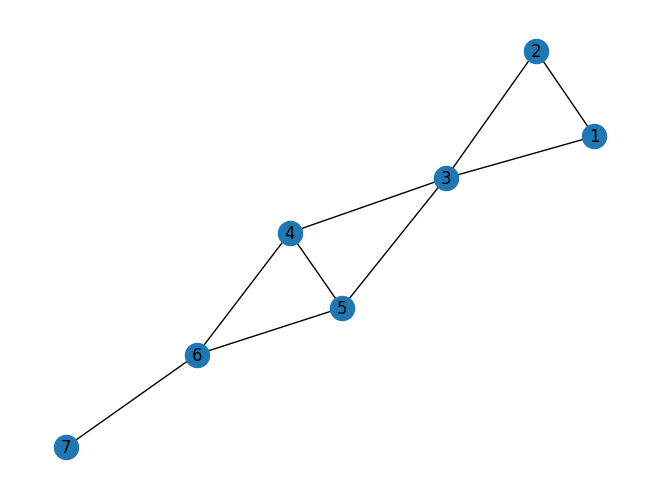

In [2]:
# Creamos un gráfico vacío
G = nx.Graph()

# Añadimos nodo y arcos al gráfico.
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (6, 7)])

nx.draw(G, with_labels = True)
plt.show()

```{index} dnx.maximum_independent_set, maximum_independent_set
```

Procedemos a resolver este problema, bien entendido que Ocean SDK ya tiene el método <a href="https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/stable/reference/algorithms/generated/dwave_networkx.maximum_independent_set.html" target="_blank"> maximum_independent_set </a>.

In [3]:
sampler = EmbeddingComposite(DWaveSampler())


# Encontrar el maximum independent set, S
S = dnx.maximum_independent_set(G, sampler=sampler, num_reads=10, label='Ejemplo - Antenna Selection')

# Imprimimos la solución para el usuario final
print('Maximum independent set size found is', len(S))
print(S)

Maximum independent set size found is 3
[1, 4, 7]


In [4]:
# Visualizamos el resultado
k = G.subgraph(S)
notS = list(set(G.nodes()) - set(S))
othersubgraph = G.subgraph(notS)
pos = nx.spring_layout(G)
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

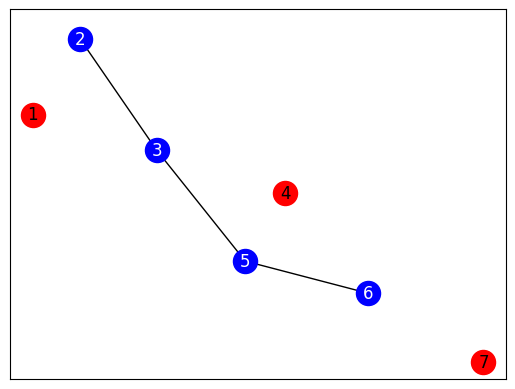

In [6]:
# Mostramos la solución
# Nota: Los nodos rojos son la solución, los azules no son elegidos.
#solution_name = "antenna_plot_solution.png"
nx.draw_networkx(k, pos=pos, with_labels=True, node_color='r', font_color='k')
nx.draw_networkx(othersubgraph, pos=pos, with_labels=True, node_color='b', font_color='w')
#plt.savefig(solution_name, bbox_inches='tight')
plt.show()

(colocacion_antenas)=
## Colocación de antenas en Alemania.

Ahora procedemos a resolver el segundo de los problemas planteados. Se trata de lo siguiente.

Tenemos las ubicaciones (la latitud y la longitud) de las torres de televisión en Alemania (estos datos <a href="https://github.com/dwave-examples/antenna-selection/tree/master/data" target="_blank"> se pueden descargar desde este enlace </a>), entonces sabiendo estos datos de lo que se trata es de determinar dónde deberían construirse nuevas torres de televisión para ampliar la cobertura sobre el territorio de alemania, pero con la restricción de que la interferencia entre ellas sea la menor posible.

Resolveremos este problema utilizando el sampler *LeapHybridCQMSampler* y  formulando un problema de tipo Constrained Quadratic Model (CQM) de la manera que vamos a indicar en los siguientes apartados. 

Debemos de tener en cuenta que en lugar de formular este problema como un problema de tipo *independent set problem*, donde no se tolera la interferencia, optimizaremos para encontrar la cantidad mínima de interferencia, ya que **es poco probable que en el mundo real podamos eliminarla por completo**.

### Resolución del problema.

Se proporciona un mapa de Alemania con las ubicaciones de 30 torres y se identifican aleatoriamente 100 nuevas ubicaciones potenciales de torres dentro de las fronteras del país (estos datos <a href="https://github.com/dwave-examples/antenna-selection/tree/master/data" target="_blank"> se pueden descargar desde este enlace </a>).

Nuestro objetivo va a ser seleccionar un subconjunto de estas posibles ubicaciones de torres nuevas para que *las distancias por pares entre todas las torres (existentes y nuevas) sean lo más grandes posible*. En el código, hacemos esto calculando primero todas las distancias por pares. Hay que tener en cuenta que si simplemente sumamos estas distancias brutas, podríamos terminar con gran una variedad de distribuciones de distancia. Por ejemplo, podríamos tener pares de torres con distancia 1 y 9, y otros pares con distancia 5 y 5, cada uno de los cuales tiene una suma de 10. En nuestro escenario, preferiremos los pares con distancia 1 y 9.

Para rectificar esto, elevamos al cuadrado las distancias antes de sumarlas. Observar que elevar al cuadrado las distancias proporciona una distribución más uniforme. En nuestro ejemplo, esto nos proporciona sumas de distancia 1+81=82 y 25+25=50, prefiriendo los pares con distancias 1 y 9 (ya que estamos maximizando la suma).

Además, dado que la interferencia solo afecta a las torres que se encuentran dentro de cierta proximidad entre sí, vamos a  establecemos un radio de corte de la siguiente manera.

Cada par de torres con una distancia mayor que el radio de corte recibe un sesgo (bias) de valor mínimo para que no se las penalice por seleccionar ambas. Por el contrario, cada par de torres con una distancia menor que el radio de corte recibe un sesgo del negativo de la distancia al cuadrado.

Por último, agregamos una restricción para elegir exactamente 10 torres nuevas y arreglamos las variables de torre existentes para que tengan un valor de 1.0. Esto garantiza que las torres existentes se identifiquen como ubicaciones donde deben existir torres.

A continuación procedemos a implementar todo esto. Procedemos a importar los paquetes necesarios:

In [17]:
#!pip install pandas

# para instalar shapefile hacemos lo siguiente
#!pip install pyshp 

#Para instalar shapely. Esta en https://shapely.readthedocs.io/en/stable/
#!pip install shapely

In [18]:
from itertools import combinations
from math import asin, cos, radians, sin, sqrt

import matplotlib
import numpy as np
import pandas as pd
import shapefile
from dimod import Binary, ConstrainedQuadraticModel, quicksum
from dwave.system import LeapHybridCQMSampler
from shapely.geometry import Point, shape
from shapely.ops import unary_union

import matplotlib.pyplot as plt

Definimos la función que nos va a servir para medir la distancia entre dos puntos, dadas sus coordenadas de latitud y longitud.

In [19]:
def distance(lat1, long1, lat2, long2):
    ''' Calcular la distancia (en millas) entre dos puntos dadas la lat/lon.
    Args:
        - lat1, long1: float. Lat y long del punyo 1.
        - lat2, long 2: float. Lat y long del 2.
    Returns:
        - dist: float. Distancia en millas entre dos puntos.
    '''
    # obtenido de https://www.geeksforgeeks.org/program-distance-two-points-earth/

    # El módulo math contiene una función llamada 
    # radians que convierte grados en radianes.
    long1 = radians(long1)
    long2 = radians(long2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radio de la tierra en millas
    r = 3956
      
    # Devolvemos el resultado
    return(c * r)

Ahora definimos otra función que se encargará de leer los datos donde está la información de las torres existentes

In [20]:
def get_existing_towers(filename):
    ''' Cargar las torres existente.
    Args:
        - filename: string.Nombre del fichero
    Returns:
        - towers:  un data frame contenido la información de las torres existentes.
    '''

    with open(filename) as f:
        lines = f.readlines()

    points = []
    lats = []
    longs = []
    for line in lines:
        temp = line.split("\t")
        points.append(temp[0])
        lats.append(float(temp[1]))
        longs.append(float(temp[2][:-2]))

    towers = pd.DataFrame({'Name': points, 'Latitude': lats, 'Longitude':longs})

    return towers

Una vez incorporados estos elementos vamos a operar con ellos. Inicialmente cargamos el fichero de tipo shapefile con los datos geográficos de Alemania. Recordar que estos datos <a href="https://github.com/dwave-examples/antenna-selection/tree/master/data" target="_blank"> se pueden descargar desde este enlace </a>.

In [23]:
 # Load and draw country map from geojson file
print("\nCargando los datos de la planimetría ...")
shp_file = "data/germany_states.shp"
germany_map = shapefile.Reader(shp_file, encoding='CP1252')

print(type(germany_map))


Cargando los datos de la planimetría ...
<class 'shapefile.Reader'>


Cargamos las torres existentes y mostramos los primeros registros del data frame obtenido

In [24]:
# Cargamos las torres existente
existing_towers = get_existing_towers("data/locations.txt")
existing_towers.head()

,Name,Latitude,Longitude
0,"Holstein Tower, Sierksdorf, Germany",54.074089,10.77913
1,"Scream (Heide Park), Soltau, Germany",53.027111,9.87851
2,"Bremerhaven Radar Tower, Bremerhaven, Germany",53.538406,8.58029
3,"Brocken Transmitter, Weringerode, Germany",51.800194,10.61436
4,"GroÃŸer Inselsberg, Thuringia, Germany",50.851246,10.46551


Definimos una nueva función que será la que se encargue de generar nuevos puntos de forma aleatoria que serán los candidatos para la ubicación de las antenas.

In [25]:
def gen_new_points(num_new_points, region_map):
    ''' Generamos puntos aleatorios en la zona geográfica correspondiente.
    Args:
        - num_new_points: Un entero con el número de puntos a elegir.
        - region_map: gdf. Region of interes. En nuestro caso el objeto germany_map anteriormente creado
    Returns:
        - new_locs: lista de [float, float]. nuevos puntos con formato [lat, long].
    '''

    # Load the map boundaries for the region
    polys = [shape(p) for p in region_map.shapes()]
    boundary = unary_union(polys)
    min_long, min_lat, max_long, max_lat = boundary.bounds

    counter = 0
    new_locs = []

    while counter < num_new_points:
        new_long = (max_long - min_long) * np.random.random() + min_long
        new_lat = (max_lat - min_lat) * np.random.random() + min_lat
        point = Point(new_long, new_lat)

        # Check that new point is within region before appending
        if point.intersects(boundary):
            counter += 1
            new_locs.append([new_lat, new_long])

    return new_locs

Ahora elegimos 100 puntos

In [26]:
# Seleccione puntos aleatorios dentro de las fronteras del país
num_new = 100
new_locs = gen_new_points(num_new, germany_map)
# Definimos el núemro de puntos que realmente vamos a seleccionar para ubicar las antenas
num_to_build = 10

In [28]:
# Vemos la información de los nuevos puntos
new_locs[:10]

[[54.607001359203274, 13.377615922133907],
 [51.57380569840487, 11.182334683288005],
 [50.86773756688333, 9.252691648656352],
 [52.53996854738223, 7.703400252542739],
 [50.73759613854149, 12.030663362624013],
 [51.26265388669497, 8.801254770563828],
 [53.709061436655816, 7.20536122574036],
 [51.25140175633949, 11.301464814378537],
 [49.13664181989654, 8.138657995498052],
 [48.64721718442703, 13.121211074740703]]

Una vez creado toda la infraestructura procedemos a definir la función que nos creará el objeto de tipo Constrained Quadratic Model o CQM que nos resuelve el problema.

Pero antes y para una mejor comprensión del código que constituye la función build_cqm, vamos a ver algo de su contenido y cómo se construyen algunos de los elementos de esa función.

Comenzando viendo el elemento *towers_vars*. Lo que se hace es pasar los datos de un data frame y convertirlos en un diccionario

In [30]:
tower_vars = {(row['Latitude'],row['Longitude'],row['Name']): Binary(row['Name']) for _, row in existing_towers.iterrows()}

In [34]:
# Veamos el contenido del diccionario tower_vars
for x in list(tower_vars)[0:3]:
    print ("key: {}, value; {} ".format(x,  tower_vars[x]))

key (54.074089, 10.77913, 'Holstein Tower, Sierksdorf, Germany'), value BinaryQuadraticModel({'Holstein Tower, Sierksdorf, Germany': 1.0}, {}, 0.0, 'BINARY') 
key (53.027111, 9.87851, 'Scream (Heide Park), Soltau, Germany'), value BinaryQuadraticModel({'Scream (Heide Park), Soltau, Germany': 1.0}, {}, 0.0, 'BINARY') 
key (53.538406, 8.58029, 'Bremerhaven Radar Tower, Bremerhaven, Germany'), value BinaryQuadraticModel({'Bremerhaven Radar Tower, Bremerhaven, Germany': 1.0}, {}, 0.0, 'BINARY') 


Algo similar se hace con *new_locs*, con estos datos se construye un diccionario:

In [35]:
new_vars = {(new_locs[n][0],new_locs[n][1]): Binary(n) for n in range(len(new_locs))}

In [36]:
# Veamos el contenido del diccionario new_vars
for x in list(new_vars)[0:3]:
    print ("key: {}, value; {} ".format(x,  new_vars[x]))

key: (54.607001359203274, 13.377615922133907), value; BinaryQuadraticModel({0: 1.0}, {}, 0.0, 'BINARY') 
key: (51.57380569840487, 11.182334683288005), value; BinaryQuadraticModel({1: 1.0}, {}, 0.0, 'BINARY') 
key: (50.86773756688333, 9.252691648656352), value; BinaryQuadraticModel({2: 1.0}, {}, 0.0, 'BINARY') 


Con la expresión *all_vars.update(new_vars)*, lo que hacemos es integrar los dos diccionarios en uno solo. 

Con la función *combinations* lo que hacemos es obtener todas las combinaciones posibles entre pares de ubicación de las antenas, tanto de las ya existentes, como de las nuevas:

In [39]:
all_vars = tower_vars.copy()
all_vars.update(new_vars)
list(combinations(all_vars.keys(), 2))[:3]

[((54.074089, 10.77913, 'Holstein Tower, Sierksdorf, Germany'),
  (53.027111, 9.87851, 'Scream (Heide Park), Soltau, Germany')),
 ((54.074089, 10.77913, 'Holstein Tower, Sierksdorf, Germany'),
  (53.538406, 8.58029, 'Bremerhaven Radar Tower, Bremerhaven, Germany')),
 ((54.074089, 10.77913, 'Holstein Tower, Sierksdorf, Germany'),
  (51.800194, 10.61436, 'Brocken Transmitter, Weringerode, Germany'))]

```{index} cqm.fix_variables, fix_variables
```
Observar la última instrucció <a href="https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.ConstrainedQuadraticModel.fix_variables.html" target="_blank">n  cqm.fix_variable </a>, instrucción que obliga al modelo a dar el valor de 1 a las variables qye representan las torres ya existentes.s

In [40]:
def build_cqm(num_to_build, existing_towers, new_locs, radius):
    ''' Creación del modelo CQM buscado.
    Args:
        - num_to_build: entero. Número de nevas antenas a construir.
        - existing_towers: dataframe. Indicación donde están ya están las antenas.
        - new_locs: Lista de [float, float]. Lista de potenciales sitios donde colocar las nueva antenas lat/long.
        - radius: int or float. Radio de distancia de interferencia.
    Returns:
        - cqm: ConstrainedQuadraticModel representando el problema a optimizar.
    '''

    # inicializamos el modelo
    cqm = ConstrainedQuadraticModel()

    # construcción de variables para el  CQM.
    tower_vars = {(row['Latitude'],row['Longitude'],row['Name']): Binary(row['Name']) for _, row in existing_towers.iterrows()}
    new_vars = {(new_locs[n][0],new_locs[n][1]): Binary(n) for n in range(len(new_locs))}

    
    # Hacemos una combinación de todas las variables para calcular la función objetivo
    all_vars = tower_vars.copy()
    all_vars.update(new_vars)

    # Objectivo: minimizar interferencias / maximizar distancias
    pair_list = list(combinations(all_vars.keys(), 2)) 
    # Calculamos las distancias entre todos los puntos dos a dos (las combinaciones anteriores)
    dist = [distance(a[0], a[1], b[0], b[1])**2 for (a, b) in pair_list]
    max_dist = max(dist) 
    biases = [dist[i] if dist[i] < radius**2 else max_dist for i in range(len(dist))]

    # Definimos la función objetivo. Ponemos un valor negativo porque queremos maximizar
    cqm.set_objective(quicksum(-biases[i]*all_vars[pair_list[i][0]]*all_vars[pair_list[i][1]] for i in range(len(pair_list))))

    # restricción:  tomamos exactamente num_to_build  como nuevos lugares para instalar las antenas
    cqm.add_constraint(quicksum(new_vars.values()) == num_to_build)

    # Fijamos el valor de 1 para las torres de antenas ya existentes.
    cqm.fix_variables({key[2]: 1.0 for key in tower_vars.keys()})

    return cqm

Ahora ya utilizamos la función anterior para construir el modelo CQM que se va a utilizar y una vez construido creamos una instancia del solver LeapHybridCQMSampler().

In [41]:
print("\Construyo el modelo CQM...")
cqm = build_cqm(num_to_build, existing_towers, new_locs, radius=75)

# Initialize the CQM solver
sampler = LeapHybridCQMSampler()

\Construyo el modelo CQM...


In [42]:
# Resolvemos el problema con el CQM solver
print("\nenviando el rpblema al hybrid solver...")
sampleset = sampler.sample_cqm(cqm, label='Example - TV Towers')
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)

try:
    sample = feasible_sampleset.first.sample
except:
    print("\nNo se han encontrado soluciones factibles.")
    exit()


Sending problem to hybrid solver...


In [43]:
def visualize(region_map, existing_towers, new_locs, build_sites, guardar='N'):
    ''' Visualizamos las torres encontradas.
    Args:
        - region_map: gdf. Mapa de la región.
        - existing_towers: df. Dataframe conteniendo información de las torres.
        - new_locs: lista de [float, float]. Nuevos puntos como [lat, long].
        - build_sites: lista de [float, float]. Puntos construidos [lat, long].
        - guardar: boolen. 'N' No se guarda el mapa, si en caso otro valor
    Returns:
        None.
    '''

    print("\nVisualizando la solución...")

    # Inicializando figura y ejes
    _, (ax, ax_final) = plt.subplots(nrows=1, ncols=2, figsize=(32, 12))
    ax.axis('off')
    ax_final.axis('off')

    # Dibujar los bordes de la región
    polys = [shape(p) for p in region_map.shapes()]
    boundary = unary_union(polys)
    for geom in boundary.geoms:    
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#d3d3d3', ec='none', zorder=0)
        ax_final.fill(xs, ys, alpha=0.5, fc='#d3d3d3', ec='none', zorder=0)

    # Dibujando las torres existentes
    ax.scatter(existing_towers.Longitude, existing_towers.Latitude, color='r', zorder=2)
    ax_final.scatter(existing_towers.Longitude, existing_towers.Latitude, color='r', zorder=2)

    # Dibujar radio de las torres existentes
    radius = 30
    ax.scatter(existing_towers.Longitude, existing_towers.Latitude, color='r', alpha=0.1, s=radius**2, zorder=1)
    ax_final.scatter(existing_towers.Longitude, existing_towers.Latitude, color='r', alpha=0.1, s=radius**2, zorder=1)

    # Dibujando nuevos puntos potenciales
    new_locations = pd.DataFrame(new_locs, columns=['Latitude','Longitude'])
    ax.scatter(new_locations.Longitude, new_locations.Latitude, color='y', zorder=8)

    # Dibujando los nuevos puntos seleccionados
    new_builds = pd.DataFrame(build_sites, columns=['Latitude','Longitude'])
    ax_final.scatter(new_builds.Longitude, new_builds.Latitude, color='b', zorder=8)

    # Dibujan do radios
    ax_final.scatter(new_builds.Longitude, new_builds.Latitude, color='b', alpha=0.1, s=radius**2, zorder=8)

    # Hacemos la figura
    ax.axis('scaled')
    ax_final.axis('scaled')
    ax.set_title("sitios potenciales", fontsize = 24)
    ax_final.set_title("Sitios obtenidos", fontsize = 24)

    if guardar=='N':
        plt.show()
    else:
        # Gyardamos la figura
        plot_filename = 'map.png'
        plt.savefig(plot_filename)
        print("\nOutput guardado como", plot_filename)

Utilizamos la función anterior para visualizar el mapa con las antenas


Seleccionados 10 build sites.

Visualizando la solución...


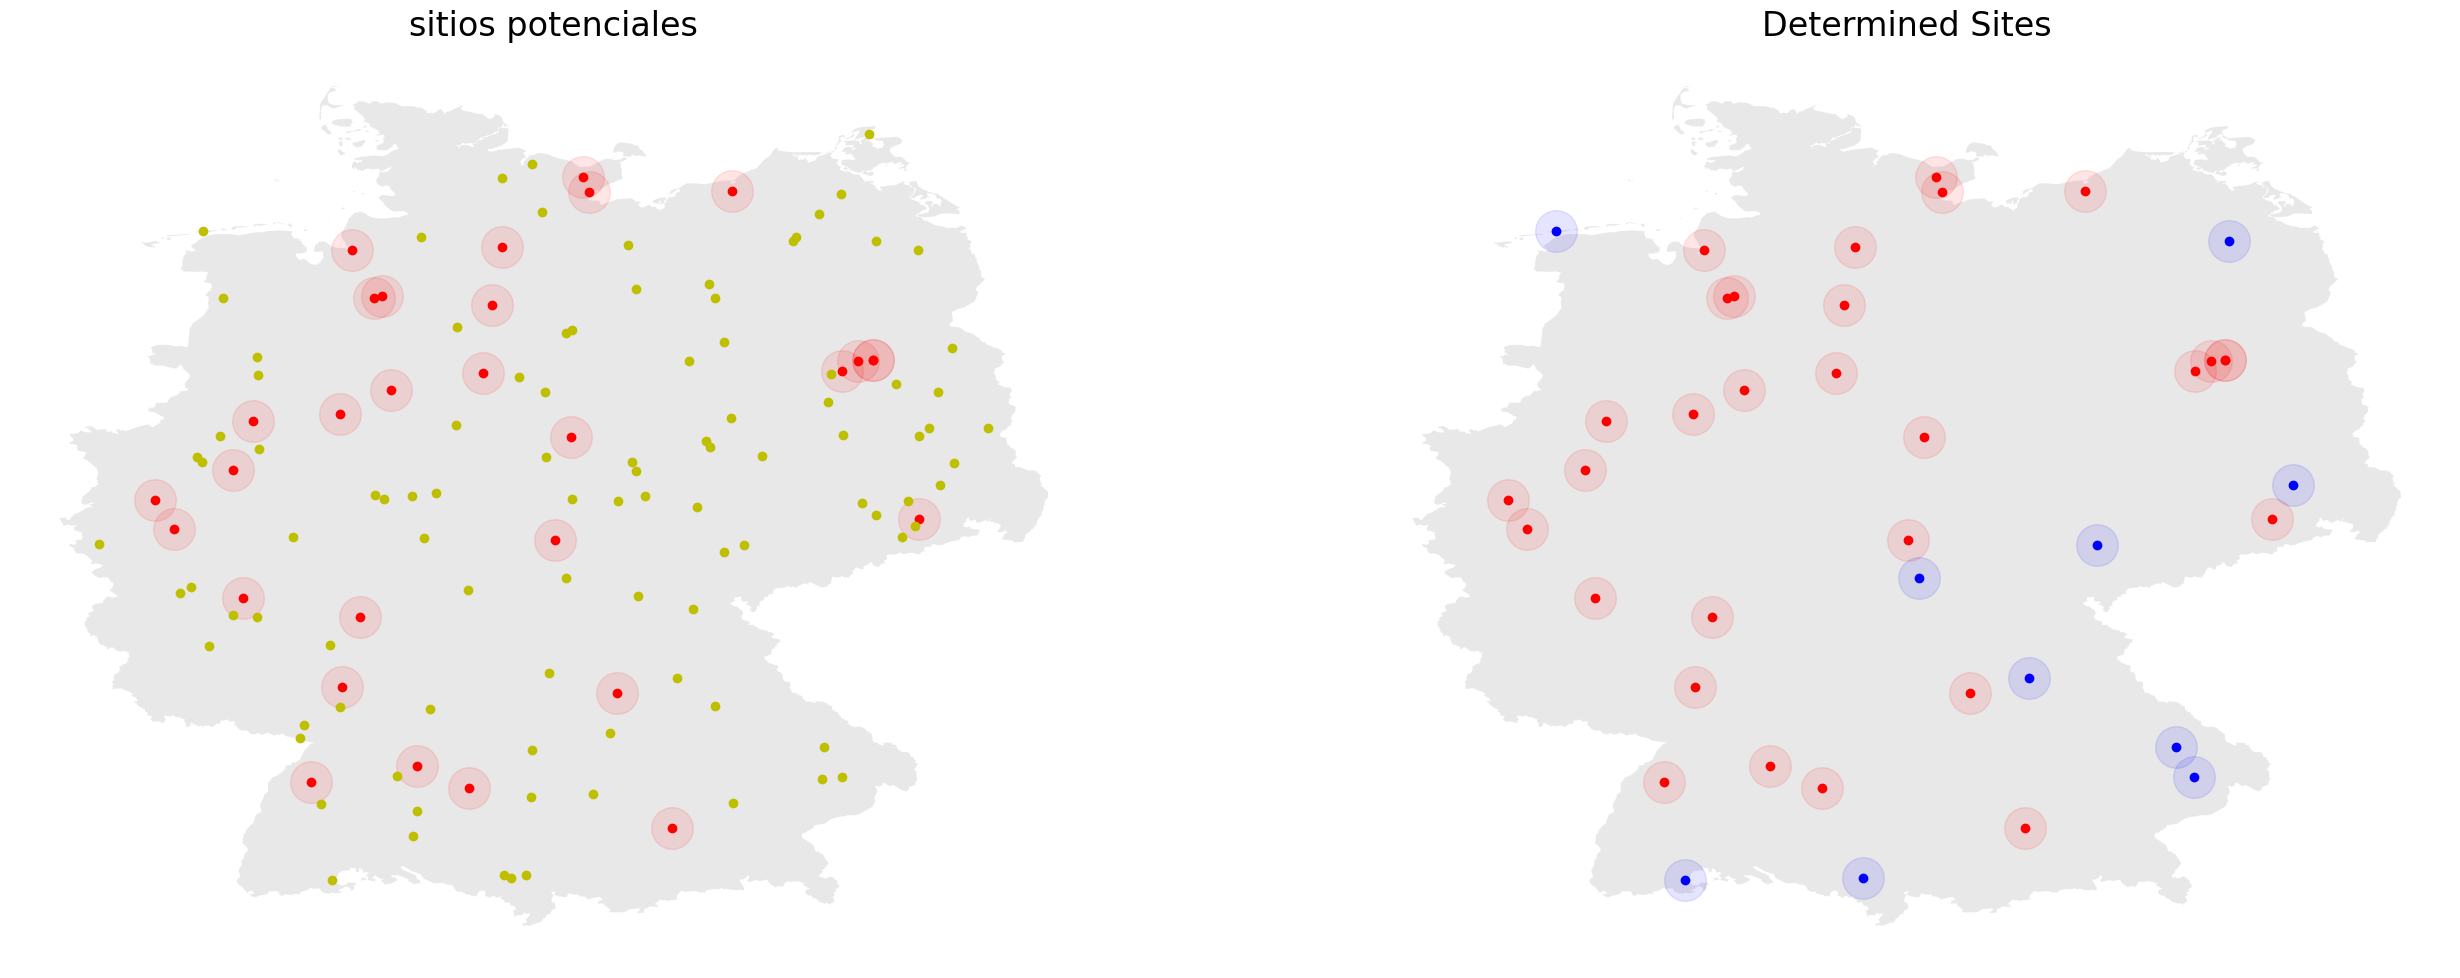

In [44]:
build_sites = [new_locs[key] for key, val in sample.items() if val == 1.0]
print("\nSeleccionados", len(build_sites), "build sites.")

visualize(germany_map, existing_towers, new_locs, build_sites)